**Author :** SUN Lauria

# Challenge IMA205 : Predicting the health situation of a patient

## Importing librairies 

In [42]:
from sklearn.exceptions import ConvergenceWarning
import warnings
import os
import numpy as np
import pandas as pd
from skimage.io import imread
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from scipy.ndimage.morphology import binary_fill_holes
from nibabel import concat_images

%matplotlib inline

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

import nibabel as nib
import cv2

## 1. Quick overview of the dataset : Data Visualization 

### 1.1 Importing data

In [33]:
# Read data
Working_directory = "./ima205-challenge-2023/"
df_train = pd.read_csv(Working_directory + 'metaDataTrain.csv')  # reading data
df_test = pd.read_csv(Working_directory + 'metaDataTest.csv')

In [34]:
df_train

,Id,Category,Height,Weight
0,1,2,184.0,95.0
1,2,2,160.0,70.0
2,3,2,165.0,77.0
3,4,2,159.0,46.0
4,5,2,165.0,77.0
...,...,...,...,...
95,96,4,186.0,76.0
96,97,4,187.0,82.0
97,98,4,167.0,50.0
98,99,4,180.0,80.0


In [35]:
df_test.head()

,Id,Height,Weight
0,101,167.0,89.0
1,102,137.0,35.0
2,103,167.0,116.0
3,104,160.0,98.0
4,105,174.0,64.0


In [36]:
# (e) Create a dataFrame df_coef and store the R2 coefficients of the estimated model
df_coef = pd.DataFrame()

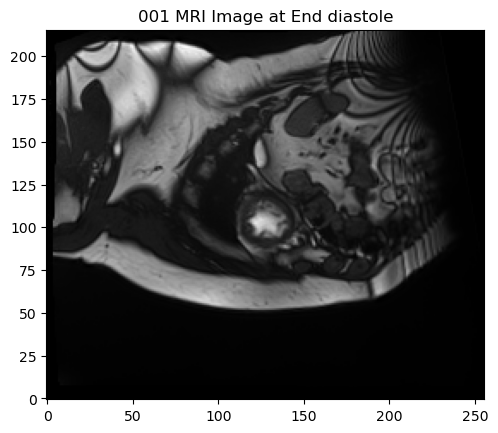

Shape of 001 MRI Images : (216, 256, 10)


In [39]:
file_idx = 1

ed_seg_path = "{}/Train/{:03d}/{:03d}_ED_seg.nii".format(
        Working_directory, file_idx, file_idx)
ed_seg = nib.load(ed_seg_path)

ed_im_path = "{}/Train/{:03d}/{:03d}_ED.nii".format(
    Working_directory, file_idx, file_idx)
ed_im = nib.load(ed_seg_path)

es_seg_path = "{}/Train/{:03d}/{:03d}_ES_seg.nii".format(
    Working_directory, file_idx, file_idx)
es_seg = nib.load(es_seg_path)

es_im_path = "{}/Train/{:03d}/{:03d}_ES.nii".format(
    Working_directory, file_idx, file_idx)
es_im = nib.load(es_im_path)

# Get image data as NumPy arrays
ed_data = ed_im.get_fdata()
es_data = es_im.get_fdata()
ed_seg_data = ed_seg.get_fdata().astype(np.int32)
es_seg_data = es_seg.get_fdata().astype(np.int32)

plt.imshow(data[:, :, 9], cmap='gray', origin='lower')
plt.title("{:03d} MRI Image at End diastole".format(file_idx))
plt.show()

print("Shape of {:03d} MRI Images : {}".format(file_idx, data.shape))

***
## II. Pre-processing : segmentation of test set

In [41]:
# Set the number of files and images per file
n_files = 151

# Loop over each file
for file_idx in range(101, n_files):
    # Loop over each image in the file
    # Load the image from the file
    partial_ed_seg_path = "{}/Test/{:03d}/{:03d}_ED_seg.nii".format(
        Working_directory, file_idx, file_idx)
    partial_ed_seg = nib.load(partial_ed_seg_path)

    partial_es_seg_path = "{}/Test/{:03d}/{:03d}_ES_seg.nii".format(
        Working_directory, file_idx, file_idx)
    partial_es_seg = nib.load(partial_es_seg_path)

    partial_ed_seg_data = partial_ed_seg.get_fdata().astype(np.int32)
    partial_es_seg_data = partial_es_seg.get_fdata().astype(np.int32)

    partial_ed_seg_data = (partial_ed_seg_data == 2)
    partial_es_seg_data = (partial_es_seg_data == 2)

    for i in range(partial_ed_seg_data.shape[2]):

        t_myo_ed_seg_data = partial_ed_seg_data[:, :, i]
        t_myo_es_seg_data = partial_ed_seg_data[:, :, i]

        # Apply binary_fill_holes to fill the partial segmentation
        myo_ed_seg_data = binary_fill_holes(t_myo_ed_seg_data).astype(np.uint8)
        myo_es_seg_data = binary_fill_holes(t_myo_es_seg_data).astype(np.uint8)

        myo_ed_seg_data -= t_myo_ed_seg_data
        myo_es_seg_data -= t_myo_ed_seg_data

        #plt.imshow(myo_es_seg_data, cmap='gray', origin='lower')
        # plt.show()

        # Create a new NIfTI image with the filled segmentation data
        myo_ed_seg_img = nib.Nifti1Image(
            myo_ed_seg_data, partial_ed_seg.affine, partial_ed_seg.header)
        myo_es_seg_img = nib.Nifti1Image(
            myo_es_seg_data, partial_es_seg.affine, partial_es_seg.header)

        # Save the new image to the same directory as the original partial segmentation file
        myo_ed_seg_path = "{}/Test/{:03d}/{:03d}_myo_ED_seg_slice_{:02d}.nii".format(
            Working_directory, file_idx, file_idx, i)
        nib.save(myo_ed_seg_img, myo_ed_seg_path)
        myo_es_seg_path = "{}/Test/{:03d}/{:03d}_myo_ES_seg_slice_{:02d}.nii".format(
            Working_directory, file_idx, file_idx, i)
        nib.save(myo_es_seg_img, myo_es_seg_path)

        #img = nib.load(myo_ed_seg_path)
        #data = img.get_fdata()
        #plt.imshow(data, cmap='gray', origin='lower')
        # plt.show()

In [43]:
n_files = 151

# Loop over each file
for file_idx in range(101, n_files):

    # Create an empty list to store the 2D image data
    myo_ed_seg_data_list = []
    myo_es_seg_data_list = []

    # Load the image from the file
    init_partial_ed_seg_path = "{}/Test/{:03d}/{:03d}_ED_seg.nii".format(
        Working_directory, file_idx, file_idx)
    init_partial_ed_seg = nib.load(init_partial_ed_seg_path)
    init_partial_es_seg_path = "{}/Test/{:03d}/{:03d}_ES_seg.nii".format(
        Working_directory, file_idx, file_idx)
    init_partial_es_seg = nib.load(init_partial_es_seg_path)

    init_partial_ed_seg_data = init_partial_ed_seg.get_fdata().astype(np.int32)
    init_partial_es_seg_data = init_partial_es_seg.get_fdata().astype(np.int32)

    partial_ed_seg_data = (init_partial_ed_seg_data == 2)
    partial_es_seg_data = (init_partial_es_seg_data == 2)

    for i, j in zip(range(partial_ed_seg_data.shape[2]), range(partial_es_seg_data.shape[2])):

        t_myo_ed_seg_data = partial_ed_seg_data[:, :, i]
        t_myo_es_seg_data = partial_es_seg_data[:, :, j]

        # Apply binary_fill_holes to fill the partial segmentation
        myo_ed_seg_data = binary_fill_holes(t_myo_ed_seg_data).astype(np.uint8)
        myo_es_seg_data = binary_fill_holes(t_myo_es_seg_data).astype(np.uint8)

        myo_ed_seg_data -= t_myo_ed_seg_data
        myo_es_seg_data -= t_myo_es_seg_data

        # Append the 2D image data to the list
        myo_ed_seg_data_list.append(myo_ed_seg_data)
        myo_es_seg_data_list.append(myo_es_seg_data)

    # Concatenate the 2D image data list into a 3D image data array
    myo_ed_seg_data = np.dstack(myo_ed_seg_data_list)
    myo_es_seg_data = np.dstack(myo_es_seg_data_list)

    # Create a new NIfTI image with the 3D image data
    myo_ed_seg_img = nib.Nifti1Image(
        myo_ed_seg_data, partial_ed_seg.affine, partial_ed_seg.header)
    myo_es_seg_img = nib.Nifti1Image(
        myo_es_seg_data, init_partial_es_seg.affine, init_partial_es_seg.header)

    # Save the new image to the same directory as the original partial segmentation files
    myo_ed_seg_path = "{}/Test/{:03d}/{:03d}_myo_ED_seg.nii".format(
        Working_directory, file_idx, file_idx)
    nib.save(myo_ed_seg_img, myo_ed_seg_path)
    myo_es_seg_path = "{}/Test/{:03d}/{:03d}_myo_ES_seg.nii".format(
        Working_directory, file_idx, file_idx)
    nib.save(myo_es_seg_img, myo_es_seg_path)

    # Create an empty list to store the 2D image data
    myo_ed_seg_data_list = []
    partial_ed_seg_data_list = []
    myo_es_seg_data_list = []
    partial_es_seg_data_list = []

    myo_ed_seg = nib.load(myo_ed_seg_path)
    myo_es_seg = nib.load(myo_es_seg_path)

    partial_ed_seg_data = init_partial_ed_seg.get_fdata().astype(np.int32)
    myo_ed_seg_data = myo_ed_seg.get_fdata().astype(np.int32)
    partial_es_seg_data = init_partial_es_seg.get_fdata().astype(np.int32)
    myo_es_seg_data = myo_es_seg.get_fdata().astype(np.int32)

    # Combine the two segmentations
    full_ed_seg_data = np.zeros_like(partial_ed_seg_data)
    full_ed_seg_data[myo_ed_seg_data == 1] = 3
    full_ed_seg_data[partial_ed_seg_data == 2] = 2
    full_ed_seg_data[partial_ed_seg_data == 1] = 1
    full_es_seg_data = np.zeros_like(partial_es_seg_data)
    full_es_seg_data[myo_es_seg_data == 1] = 3
    full_es_seg_data[partial_es_seg_data == 2] = 2
    full_es_seg_data[partial_es_seg_data == 1] = 1

    # Create a new NIfTI image with the 3D image data
    full_ed_seg_img = nib.Nifti1Image(
        full_ed_seg_data, partial_ed_seg.affine, partial_ed_seg.header)
    full_es_seg_img = nib.Nifti1Image(
        full_es_seg_data, init_partial_es_seg.affine, init_partial_es_seg.header)

    # Save the new image to the same directory as the original partial segmentation files
    full_ed_seg_path = "{}/Test/{:03d}/{:03d}_full_ED_seg.nii".format(
        Working_directory, file_idx, file_idx)
    nib.save(full_ed_seg_img, full_ed_seg_path)
    full_es_seg_path = "{}/Test/{:03d}/{:03d}_full_ES_seg.nii".format(
        Working_directory, file_idx, file_idx)
    nib.save(full_es_seg_img, full_es_seg_path)

(174, 208, 16)


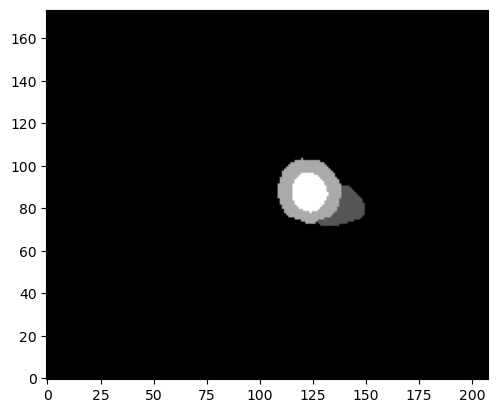

In [44]:
img = nib.load(Working_directory + 'Test/107/107_full_ES_seg.nii')
data = img.get_fdata()
print(data.shape)
plt.imshow(data[:, :, 10], cmap='gray', origin='lower')
plt.show()

***
## 3. Extraction of features

### 3.1 Functions for feature extraction

In [48]:
def thickness_myo(img):
    img = img.astype(np.uint8)
    thickness = np.zeros(img.shape[2])
    for k in range(img.shape[2]):
        dist_transform = cv2.distanceTransform(
            img[:, :, k], cv2.DIST_L2, 5)
        thickness[k] = dist_transform.max() - dist_transform.min()
    return thickness

In [49]:
def volume(data, img):
    volumes = np.zeros(len(img.shape)+1)
    for label_val in range(1, len(img.shape)+1):
        volumes[label_val] = np.sum(
            data == label_val) * np.prod(img.header.get_zooms())
    return volumes

In [50]:
def ejection_fraction(es_data, es_img, ed_data, ed_img):
    ef = np.zeros(3)
    ed_lv_volume = volume(ed_data, ed_img)[
        3] + volume(ed_data, ed_img)[2] + volume(ed_data, ed_img)[1]
    es_lv_volume = volume(es_data, es_img)[
        3] + volume(es_data, es_img)[2] + volume(es_data, es_img)[1]
    ef_global = (ed_lv_volume - es_lv_volume) / ed_lv_volume
    lv_ef = (volume(ed_data, ed_img)[
             3] - volume(es_data, es_img)[3]) / volume(ed_data, ed_img)[3]
    rv_ef = (volume(ed_data, ed_img)[
             1] - volume(es_data, es_img)[1]) / volume(ed_data, ed_img)[1]
    ef=[ef_global,lv_ef,rv_ef]
    return ef

In [57]:
def circularity(data, img, j):
    max_circum_list = []
    min_circum_list = []

    for i in range(data.shape[2]):
        
        # Calculate circularity and circumference of RVC and Myocardium
        # RVC = 2, Myocardium = 1
        mask = (data[:, :, i] == j)
        contours, hierarchy = cv2.findContours(
            (mask.astype(np.uint8)*255), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        max_circumference = 0
        min_circumference = np.inf
        total_circularity = 0
        for contour in contours:
            area = cv2.contourArea(contour)
            perimeter = cv2.arcLength(contour, closed=True)
            if (perimeter != 0):
                circularity = 4 * np.pi * area / (perimeter ** 2)
            else:
                circularity = 0
            max_circumference = max(max_circumference, perimeter)
            min_circumference = min(min_circumference, perimeter)
            total_circularity += circularity
        max_circum_list.append(max_circumference)
        min_circum_list.append(min_circumference)
        
        return [max_circum_list, min_circum_list]

### 3.2 Train set

In [51]:
# Set the number of files and images per file
n_files = 101

# Loop over each file
for file_idx in range(1, n_files):
    # Loop over each image in the file
    # Load the image from the file
    ed_seg_path = "{}/Train/{:03d}/{:03d}_ED_seg.nii".format(
        Working_directory, file_idx, file_idx)
    ed_seg = nib.load(ed_seg_path)

    ed_im_path = "{}/Train/{:03d}/{:03d}_ED.nii".format(
        Working_directory, file_idx, file_idx)
    ed_im = nib.load(ed_seg_path)

    es_seg_path = "{}/Train/{:03d}/{:03d}_ES_seg.nii".format(
        Working_directory, file_idx, file_idx)
    es_seg = nib.load(es_seg_path)

    es_im_path = "{}/Train/{:03d}/{:03d}_ES.nii".format(
        Working_directory, file_idx, file_idx)
    es_im = nib.load(es_im_path)

    # Get image data as NumPy arrays
    ed_data = ed_im.get_fdata()
    es_data = es_im.get_fdata()
    ed_seg_data = ed_seg.get_fdata().astype(np.int32)
    es_seg_data = es_seg.get_fdata().astype(np.int32)

    # Store results in a DataFrame
    df_train.loc[file_idx-1, 'End diastole volume (RV)'] = volume(ed_seg_data, ed_seg)[1]
    df_train.loc[file_idx-1, 'End diastole volume (LV)'] = volume(ed_seg_data, ed_seg)[3]
    df_train.loc[file_idx-1,
                 'End diastole volume (Myocardium)'] = volume(ed_seg_data, ed_seg)[2]
    df_train.loc[file_idx-1, 'End systole volume (RV)'] = volume(es_seg_data, es_seg)[1]
    df_train.loc[file_idx-1, 'End systole volume (LV)'] = volume(es_seg_data, es_seg)[3]
    df_train.loc[file_idx-1, 'End systole volume (Myocardium)'] = volume(es_seg_data, es_seg)[2]
    df_train.loc[file_idx-1,
                 'Myocardial thickness Mean (ED)'] = np.mean(thickness_myo(ed_seg_data))
    df_train.loc[file_idx-1,
                 'Myocardial thickness Max (ED)'] = np.max(thickness_myo(ed_seg_data))
    df_train.loc[file_idx-1,
                 'Myocardial thickness Min (ED)'] = np.min(thickness_myo(ed_seg_data))
    df_train.loc[file_idx-1,
                 'Myocardial thickness Std (ED)'] = np.std(thickness_myo(ed_seg_data))
    df_train.loc[file_idx-1,
                 'Myocardial thickness Mean (ES)'] = np.mean(thickness_myo(es_seg_data))
    df_train.loc[file_idx-1,
                 'Myocardial thickness Max (ES)'] = np.max(thickness_myo(es_seg_data))
    df_train.loc[file_idx-1,
                 'Myocardial thickness Min (ES)'] = np.min(thickness_myo(es_seg_data))
    df_train.loc[file_idx-1,
                 'Myocardial thickness Std (ES)'] = np.std(thickness_myo(es_seg_data))
    df_train.loc[file_idx-1, 'Ejection fraction (Global)'] = ejection_fraction(es_seg_data, es_seg, ed_seg_data, ed_seg)[0]
    df_train.loc[file_idx-1,
                 'Volume Ratio (Myocardium)'] = ed_volumes[2]/es_volumes[2]
    df_train.loc[file_idx-1, 'Volume Ratio (LV)'] = ed_volumes[3]/es_volumes[3]
    df_train.loc[file_idx-1, 'Volume Ratio (RV)'] = ed_volumes[1]/es_volumes[1]
    df_train.loc[file_idx-1,
                 'Volume Ratio (LV/RV, ED)'] = ed_volumes[3]/ed_volumes[1]
    df_train.loc[file_idx-1,
                 'Volume Ratio (LV/RV, ES)'] = es_volumes[3]/es_volumes[1]
    df_train.loc[file_idx-1,
                 'Volume Ratio (LV/Myo, ED)'] = ed_volumes[2]/ed_volumes[3]
    df_train.loc[file_idx-1,
                 'Volume Ratio (LV/Myo, ES)'] = es_volumes[2]/es_volumes[3]
    df_train.loc[file_idx-1, 'Ejection fraction (LV)'] = ejection_fraction(es_seg_data, es_seg, ed_seg_data, ed_seg)[1]
    df_train.loc[file_idx-1, 'Ejection fraction (RV)'] = ejection_fraction(es_seg_data, es_seg, ed_seg_data, ed_seg)[2]

### 3.2 Test set

In [58]:
# Set the number of files and images per file
n_files = 151

# Loop over each file
for file_idx in range(101, n_files):
    # Loop over each image in the file
    # Load the image from the file
    ed_seg_path = "{}/Test/{:03d}/{:03d}_full_ED_seg.nii".format(
        Working_directory, file_idx, file_idx)
    ed_seg = nib.load(ed_seg_path)

    ed_im_path = "{}/Test/{:03d}/{:03d}_ED.nii".format(
        Working_directory, file_idx, file_idx)
    ed_im = nib.load(ed_seg_path)

    es_seg_path = "{}/Test/{:03d}/{:03d}_full_ES_seg.nii".format(
        Working_directory, file_idx, file_idx)
    es_seg = nib.load(es_seg_path)

    es_im_path = "{}/Test/{:03d}/{:03d}_ES.nii".format(
        Working_directory, file_idx, file_idx)
    es_im = nib.load(es_im_path)

    # Get image data as NumPy arrays
    ed_data = ed_im.get_fdata()
    es_data = es_im.get_fdata()
    ed_seg_data = ed_seg.get_fdata().astype(np.int32)
    es_seg_data = es_seg.get_fdata().astype(np.int32)

    # Store results in a DataFrame
    df_test.loc[file_idx-101, 'End diastole volume (RV)'] = volume(ed_seg_data, ed_seg)[1]
    df_test.loc[file_idx-101, 'End diastole volume (LV)'] = volume(ed_seg_data, ed_seg)[3]
    df_test.loc[file_idx-101,
                 'End diastole volume (Myocardium)'] = volume(ed_seg_data, ed_seg)[2]
    df_test.loc[file_idx-101, 'End systole volume (RV)'] = volume(es_seg_data, es_seg)[1]
    df_test.loc[file_idx-101, 'End systole volume (LV)'] = volume(es_seg_data, es_seg)[3]
    df_test.loc[file_idx-101, 'End systole volume (Myocardium)'] = volume(es_seg_data, es_seg)[2]
    df_test.loc[file_idx-101,
                 'Myocardial thickness Mean (ED)'] = np.mean(thickness_myo(ed_seg_data))
    df_test.loc[file_idx-101,
                 'Myocardial thickness Max (ED)'] = np.max(thickness_myo(ed_seg_data))
    df_test.loc[file_idx-101,
                 'Myocardial thickness Min (ED)'] = np.min(thickness_myo(ed_seg_data))
    df_test.loc[file_idx-101,
                 'Myocardial thickness Std (ED)'] = np.std(thickness_myo(ed_seg_data))
    df_test.loc[file_idx-101,
                 'Myocardial thickness Mean (ES)'] = np.mean(thickness_myo(es_seg_data))
    df_test.loc[file_idx-101,
                 'Myocardial thickness Max (ES)'] = np.max(thickness_myo(es_seg_data))
    df_test.loc[file_idx-101,
                 'Myocardial thickness Min (ES)'] = np.min(thickness_myo(es_seg_data))
    df_test.loc[file_idx-101,
                 'Myocardial thickness Std (ES)'] = np.std(thickness_myo(es_seg_data))
    df_test.loc[file_idx-101, 'Ejection fraction (Global)'] = ejection_fraction(es_seg_data, es_seg, ed_seg_data, ed_seg)[0]
    df_test.loc[file_idx-101,
                 'Volume Ratio (Myocardium)'] = ed_volumes[2]/es_volumes[2]
    df_test.loc[file_idx-101, 'Volume Ratio (LV)'] = ed_volumes[3]/es_volumes[3]
    df_test.loc[file_idx-101, 'Volume Ratio (RV)'] = ed_volumes[1]/es_volumes[1]
    df_test.loc[file_idx-101,
                 'Volume Ratio (LV/RV, ED)'] = ed_volumes[3]/ed_volumes[1]
    df_test.loc[file_idx-101,
                 'Volume Ratio (LV/RV, ES)'] = es_volumes[3]/es_volumes[1]
    df_test.loc[file_idx-101,
                 'Volume Ratio (LV/Myo, ED)'] = ed_volumes[2]/ed_volumes[3]
    df_test.loc[file_idx-101,
                 'Volume Ratio (LV/Myo, ES)'] = es_volumes[2]/es_volumes[3]
    df_test.loc[file_idx-101, 'Ejection fraction (LV)'] = ejection_fraction(es_seg_data, es_seg, ed_seg_data, ed_seg)[1]
    df_test.loc[file_idx-101, 'Ejection fraction (RV)'] = ejection_fraction(es_seg_data, es_seg, ed_seg_data, ed_seg)[2]
    df_test.loc[file_idx-101,
                'RVC max circumference'] = np.max(circularity(ed_seg_data, ed_seg, 1)[0])
    df_test.loc[file_idx-101,
                'RVC min circumference'] = np.min(circularity(ed_seg_data, ed_seg, 1)[1])
    df_test.loc[file_idx-101,
                'Myocardium max circumference'] = np.min(circularity(ed_seg_data, ed_seg, 2)[1])
    df_test.loc[file_idx-101,
                'Myocardium min circumference'] = np.min(circularity(ed_seg_data, ed_seg, 2)[1])

In [54]:
import numpy as np
import cv2

n_files = 151

# Loop over each file
for file_idx in range(101, n_files):
    # Load the images from the file
    ed_seg_path = "{}/Test/{:03d}/{:03d}_full_ED_seg.nii".format(
        Working_directory, file_idx, file_idx)
    ed_seg = nib.load(ed_seg_path)

    # Get the data arrays
    ed_seg_arr = ed_seg.get_fdata()

    rvc_max_circum_list = []
    rvc_min_circum_list = []
    rvc_mean_circu_list = []
    myo_max_circum_list = []
    myo_min_circum_list = []
    myo_mean_circu_list = []

    for i in range(ed_seg_arr.shape[2]):
        # Calculate circularity and circumference of RVC and Myocardium
        # RVC = 2
        mask = (ed_seg_arr[:, :, i] == 2)
        contours, hierarchy = cv2.findContours(
            (mask.astype(np.uint8)*255), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        max_circumference = 0
        min_circumference = np.inf
        total_circularity = 0
        for contour in contours:
            area = cv2.contourArea(contour)
            perimeter = cv2.arcLength(contour, closed=True)
            if (perimeter != 0):
                circularity = 4 * np.pi * area / (perimeter ** 2)
            else:
                circularity = 0
            max_circumference = max(max_circumference, perimeter)
            min_circumference = min(min_circumference, perimeter)
            total_circularity += circularity
        mean_circularity = total_circularity / \
            len(contours) if len(contours) > 0 else np.nan
        rvc_max_circum_list.append(max_circumference)
        rvc_min_circum_list.append(min_circumference)
        rvc_mean_circu_list.append(mean_circularity)

        #Myocardium = 1
        mask = (ed_seg_arr[:, :, i] == 1)
        contours, hierarchy = cv2.findContours(
            (mask.astype(np.uint8)*255), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        max_circumference = 0
        min_circumference = np.inf
        total_circularity = 0
        for contour in contours:
            area = cv2.contourArea(contour)
            perimeter = cv2.arcLength(contour, closed=True)
            if (perimeter != 0):
                circularity = 4 * np.pi * area / (perimeter ** 2)
            else:
                circularity = 0
            max_circumference = max(max_circumference, perimeter)
            min_circumference = min(min_circumference, perimeter)
            total_circularity += circularity
        mean_circularity = total_circularity / \
            len(contours) if len(contours) > 0 else np.nan
        myo_max_circum_list.append(max_circumference)
        myo_min_circum_list.append(min_circumference)
        myo_mean_circu_list.append(mean_circularity)

        # Add the results to the dataframe
    df_test.loc[file_idx-101,
                'RVC mean circularity'] = np.mean(rvc_mean_circu_list)
    df_test.loc[file_idx-101,
                'RVC max circumference'] = np.max(rvc_max_circum_list)
    df_test.loc[file_idx-101,
                'RVC min circumference'] = np.min(rvc_min_circum_list)
    df_test.loc[file_idx-101,
                'Myocardium mean circularity'] = np.mean(myo_mean_circu_list)
    df_test.loc[file_idx-101,
                'Myocardium max circumference'] = np.max(myo_max_circum_list)
    df_test.loc[file_idx-101,
                'Myocardium min circumference'] = np.min(myo_min_circum_list)

In [55]:
df_test

,Id,Height,Weight,End diastole volume (RV),End diastole volume (LV),End diastole volume (Myocardium),End systole volume (RV),End systole volume (LV),End systole volume (Myocardium),Myocardial thickness Mean (ED),...,"Volume Ratio (LV/Myo, ED)","Volume Ratio (LV/Myo, ES)",Ejection fraction (LV),Ejection fraction (RV),RVC mean circularity,RVC max circumference,RVC min circumference,Myocardium mean circularity,Myocardium max circumference,Myocardium min circumference
0,101,167.0,89.0,117330.198956,227675.670574,125725.092064,84921.052303,194309.057552,149924.013100,21.374886,...,0.891461,1.279009,0.146553,0.276222,0.885174,169.338094,75.012193,NaN,155.438599,47.213203
1,102,137.0,35.0,263546.762386,115038.679577,66079.486698,98704.196892,33127.914619,43250.332975,12.956299,...,0.891461,1.279009,0.712028,0.625477,NaN,104.568541,30.727922,NaN,161.438599,56.041630
2,103,167.0,116.0,155602.979347,113275.972363,102765.830597,94458.007812,41748.046875,128100.585938,18.366409,...,0.891461,1.279009,0.631448,0.392955,0.869077,138.953318,68.769552,NaN,176.024385,64.769553
3,104,160.0,98.0,174441.912701,127377.630077,141016.577148,55197.727791,19925.762894,143349.601906,20.266860,...,0.891461,1.279009,0.843569,0.683575,0.872275,165.681239,97.740114,0.599096,178.610171,63.941125
4,105,174.0,64.0,346261.798420,189535.093224,149279.267216,167480.012798,50810.292978,108033.810453,15.298560,...,0.891461,1.279009,0.731921,0.516320,NaN,127.539104,39.798990,NaN,157.195958,48.627417
5,106,175.0,107.0,80225.212093,160802.965630,156814.840557,34130.859375,131762.695312,174365.234375,21.599486,...,0.891461,1.279009,0.180595,0.574562,0.883151,163.195958,90.669047,NaN,154.267026,29.798990
6,107,175.0,75.0,219589.251228,222872.293415,131101.349068,75061.625347,52310.959196,87619.087000,17.008335,...,0.891461,1.279009,0.765287,0.658173,0.880272,137.539104,64.769552,0.561329,150.710676,48.627417
7,108,185.0,104.0,145841.988148,117197.995914,124491.197014,75598.312378,41987.457275,132354.492188,15.463989,...,0.891461,1.279009,0.641739,0.481642,NaN,146.852813,85.840620,NaN,178.367531,77.012193
8,109,172.0,104.0,452244.569683,178496.139294,151923.328037,162956.124341,33878.236153,134322.383821,19.798243,...,0.891461,1.279009,0.810202,0.639673,0.876243,138.710676,48.041630,0.697990,197.580734,55.455844
9,110,162.0,60.0,362963.449276,213750.283581,126870.851753,117958.027611,51787.141743,79775.982428,17.728593,...,0.891461,1.279009,0.757721,0.675014,NaN,133.539104,48.041630,0.673227,165.195959,30.142135


***
## 3. First classification approach - KNN Method

### 3.1 Non-specific train and test datasets

In [140]:
# Step 1: Load the dataset
X_train = df_train.drop(['Category', 'Id'], axis=1)
y_train = df_train['Category']

X_test = df_test.drop('Id', axis=1)

In [141]:
# Step 2: Split the dataset into training and test sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

### 3.2 Specific train and test datasets

In [144]:
selected_features = ['Height', 'Weight', 'End diastole volume (RV)',
                     'End diastole volume (LV)', 'End diastole volume (Myocardium)',
                     'End systole volume (RV)', 'End systole volume (LV)',
                     'End systole volume (Myocardium)', 'Myocardial thickness Mean (ED)',
                     'Myocardial thickness Max (ED)', 'Myocardial thickness Min (ED)',
                     'Myocardial thickness Std (ED)', 'Myocardial thickness Mean (ES)',
                     'Myocardial thickness Max (ES)', 'Myocardial thickness Min (ES)',
                     'Myocardial thickness Std (ES)', 'Ejection fraction (Global)'
                     ]

In [136]:
X_train = df_train[selected_features].values
y_train = df_train['Category'].values

X_test = df_test[selected_features].values

In [137]:
# Step 2: Split the dataset into training and test sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

### 3.1 KNN Method (5-neighbors)

In [145]:
# Step 4: Train the KNN model on the training set
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

# Step 5: Test the KNN model on the test set
y_pred = knn.predict(X_val)

# Step 6: Evaluate the performance of the model
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

Accuracy: 1.0


### 3.2 Tuning the HyperParameters of our model

In [146]:
KNN = KNeighborsClassifier()
p_grid_KNN = {'n_neighbors': np.arange(1, 20)}

grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN,
                        scoring='accuracy', cv=5)
grid_KNN.fit(X_train, y_train)

print("Best Validation Score: {}".format(grid_KNN.best_score_))
print("Best params: {}".format(grid_KNN.best_params_))
print("Random Forest test score :", grid_KNN.score(X_val, y_val))

Best Validation Score: 0.85
Best params: {'n_neighbors': 5}
Random Forest test score : 1.0


In [147]:
best_params = grid_KNN.best_params_
KNN = KNeighborsClassifier(n_neighbors=best_params["n_neighbors"])
KNN.fit(X_train, y_train)

KNeighborsClassifier()

In [148]:
y_pred = KNN.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         3

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [149]:
# (e) Create a dataFrame df_coef and store the R2 coefficients of the estimated model
df_coef["KNN"] = pd.Series(grid_KNN.best_score_)

In [150]:
y_pred = KNN.predict(X_test)
print(y_pred)

[1 4 0 0 4 1 0 0 4 4 3 3 0 0 0 4 2 3 1 0 4 0 0 3 1 2 1 4 2 4 1 4 3 2 0 3 1
 3 2 0 2 1 2 1 4 2 0 1 1 1]


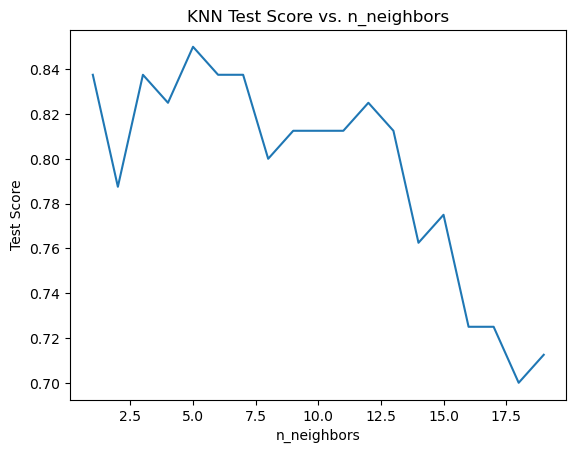

In [151]:
import matplotlib.pyplot as plt

# Get the results of the GridSearchCV
results = grid_KNN.cv_results_

# Get the test scores for each value of n_neighbors
test_scores = results['mean_test_score']

# Get the values of n_neighbors that were tested
n_neighbors = p_grid_KNN['n_neighbors']

# Plot the test scores as a function of n_neighbors
plt.plot(n_neighbors, test_scores)

# Add axis labels and title
plt.xlabel('n_neighbors')
plt.ylabel('Test Score')
plt.title('KNN Test Score vs. n_neighbors')

# Show the plot
plt.show()

### 3. Saving the data into the file

In [ ]:
# Save the predictions to a CSV file
df_sub = pd.read_csv(Working_directory + 'SampleSubmission.csv')
for i in range(len(y_pred)):
    df_sub.loc[i, 'Category'] = y_pred[i]
df_sub.to_csv(Working_directory + 'SampleSubmission.csv', index=False)

***
## 4. AdaBoost

### 4.1 Non-specific train and test datasets

In [197]:
# Step 1: Load the dataset
X_train = df_train.drop(['Category', 'Id'], axis=1)
y_train = df_train['Category']

X_test = df_test.drop('Id', axis=1)

In [199]:
# Step 2: Split the dataset into training and test sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

### 4.2 Specific train and test datasets

In [155]:
selected_features = ['Height', 'Weight', 'End diastole volume (RV)',
                     'End diastole volume (LV)', 'End diastole volume (Myocardium)',
                     'End systole volume (RV)', 'End systole volume (LV)',
                     'End systole volume (Myocardium)', 'Myocardial thickness Mean (ED)',
                     'Myocardial thickness Max (ED)', 'Myocardial thickness Min (ED)',
                     'Myocardial thickness Std (ED)', 'Myocardial thickness Mean (ES)',
                     'Myocardial thickness Max (ES)', 'Myocardial thickness Min (ES)',
                     'Myocardial thickness Std (ES)', 'Ejection fraction (Global)']

In [156]:
X_train = df_train[selected_features].values
y_train = df_train['Category'].values

X_test = df_test[selected_features].values

In [137]:
# Step 2: Split the dataset into training and test sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

In [202]:
# 3. True 0.88, avec bon ejection fraction MEILLEUR BEST BEST
selected_features = ['Height', 'Weight', 'End diastole volume (RV)',
                     'End diastole volume (LV)', 'End diastole volume (Myocardium)',
                     'End systole volume (RV)', 'End systole volume (LV)',
                     'End systole volume (Myocardium)', 'Myocardial thickness Mean (ED)',
                     'Myocardial thickness Max (ED)', 'Myocardial thickness Min (ED)',
                     'Myocardial thickness Std (ED)', 'Myocardial thickness Mean (ES)',
                     'Myocardial thickness Max (ES)', 'Myocardial thickness Min (ES)',
                     'Myocardial thickness Std (ES)', 'Ejection fraction (Global)',
                     'Volume Ratio (Myocardium)', 'Volume Ratio (LV)', 'Volume Ratio (RV)',
                     'Volume Ratio (LV/RV, ED)', 'Volume Ratio (LV/RV, ES)',
                     'Volume Ratio (LV/Myo, ED)', 'Volume Ratio (LV/Myo, ES)']

In [83]:
# Step 1: Load the dataset
X_train = df_train.drop(['Category', 'Id'], axis=1)
y_train = df_train['Category']

X_test = df_test.drop('Id', axis=1)

### 4.3 Adaboost

In [200]:
# Define the Adaboost classifier
dtc = DecisionTreeClassifier(max_depth=1)
ada = AdaBoostClassifier(
    base_estimator=dtc, n_estimators=500, learning_rate=1.0, random_state=42)

# Train the model on the training set
ada.fit(X_train, y_train)

# Evaluate the performance on the validation set
score = ada.score(X_val, y_val)
print("Validation set accuracy: {:.2f}".format(score))

# Make predictions on the test set
y_pred = ada.predict(X_test)


Validation set accuracy: 0.60


### Identifying key features

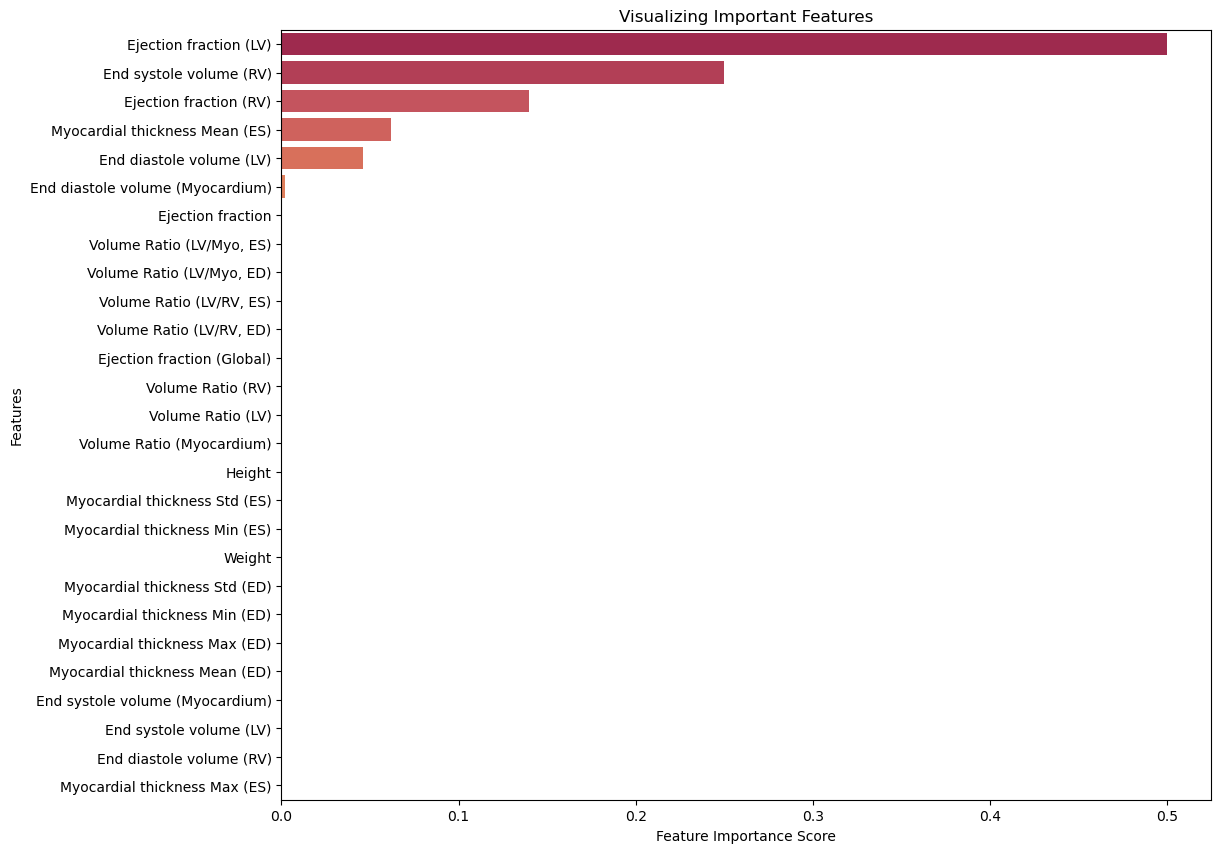

In [201]:
# Computing Feature importance scores
feature_imp = pd.Series(ada.feature_importances_, index=X_test.columns.unique()).sort_values(ascending=False)

# Plotting the scores
plt.figure(figsize=(12,10))

sns.barplot(x=feature_imp, y=feature_imp.index, palette='Spectral')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")

plt.show()
plt.close()

### 4.4 Saving the data into the file

In [ ]:
# Save the predictions to a CSV file
df_sub = pd.read_csv(Working_directory + 'SampleSubmission.csv')
for i in range(len(y_pred)):
    df_sub.loc[i, 'Category'] = y_pred[i]
df_sub.to_csv(Working_directory + 'SampleSubmission.csv', index=False)

### 4.5 Comparison

In [92]:
# (e) Create a dataFrame df_coef and store the R2 coefficients of the estimated model
df_coef["Adaboost"] = pd.Series(score)

***
## 5. Partial article 2 : Multi-Layer Perceptron 

### 5.1 Non-specific train and test datasets

In [185]:
# Step 1: Load the dataset
X_train = df_train.drop(['Category', 'Id'], axis=1)
y_train = df_train['Category']

X_test = df_test.drop('Id', axis=1)

In [141]:
# Step 2: Split the dataset into training and test sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

### 5.2 Specific train and test datasets

In [155]:
selected_features = ['Height', 'Weight', 'End diastole volume (RV)',
                     'End diastole volume (LV)', 'End diastole volume (Myocardium)',
                     'End systole volume (RV)', 'End systole volume (LV)',
                     'End systole volume (Myocardium)', 'Myocardial thickness Mean (ED)',
                     'Myocardial thickness Max (ED)', 'Myocardial thickness Min (ED)',
                     'Myocardial thickness Std (ED)', 'Myocardial thickness Mean (ES)',
                     'Myocardial thickness Max (ES)', 'Myocardial thickness Min (ES)',
                     'Myocardial thickness Std (ES)', 'Ejection fraction (Global)']

In [156]:
X_train = df_train[selected_features].values
y_train = df_train['Category'].values

X_test = df_test[selected_features].values

### 5.3 Multi-Layer Perceptron inspired from the article

In [157]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np


# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

# Train MLPs
mlp_ensemble = []
for i in range(50):
    mlp = MLPClassifier(hidden_layer_sizes=(32, 32, 32, 32),
                        activation='relu',
                        alpha=0.0001,
                        batch_size='auto',
                        learning_rate='constant',
                        learning_rate_init=0.001,
                        max_iter=400,
                        shuffle=True,
                        random_state=i)

    # Randomly select 2/3 of the features for this MLP
    selected_features = np.random.choice(
        X_train.shape[1], size=int(2/3*X_train.shape[1]), replace=False)
    mlp.fit(X_train[:, selected_features], y_train)
    mlp_ensemble.append(mlp)


# Evaluate the MLP ensemble on the validation set
mlp_scores = []
for mlp in mlp_ensemble:
    mlp_scores.append(mlp.predict_proba(X_val[:, selected_features]))

mlp_scores = np.mean(np.array(mlp_scores), axis=0)
mlp_preds = np.argmax(mlp_scores, axis=1)

acc_val = accuracy_score(y_val, mlp_preds)
print(acc_val)

# Train the random forest
#rf = RandomForestClassifier(n_estimators=1000, random_state=42)
#rf.fit(X_train, y_train)

# Evaluate the random forest on the validation set
#rf_preds = rf.predict(X_val)


# Combine the predictions from the MLP ensemble and random forest
#ensemble_preds = np.argmax(mlp_preds + rf_preds, axis=1)
#ensemble_preds = np.argmax(mlp_preds + rf_preds)

# Evaluate the ensemble on the validation set
#ensemble_acc = accuracy_score(y_val, ensemble_preds)
#print("Ensemble accuracy on validation set:", ensemble_acc)

0.16


### 5.4 Saving the data into the file

In [ ]:
# Save the predictions to a CSV file
df_sub = pd.read_csv(Working_directory + 'SampleSubmission.csv')
for i in range(len(y_pred)):
    df_sub.loc[i, 'Category'] = y_pred[i]
df_sub.to_csv(Working_directory + 'SampleSubmission.csv', index=False)

### 5.5 Comparison

In [161]:
# (e) Create a dataFrame df_coef and store the R2 coefficients of the estimated model
df_coef["MLP"] = pd.Series(acc_val)

***
## 6. Random Forest

### 6.1 Non-specific train and test datasets

In [176]:
# Step 1: Load the dataset
X_train = df_train.drop(['Category', 'Id'], axis=1)
y_train = df_train['Category']

X_test = df_test.drop('Id', axis=1)

In [263]:
# Step 2: Split the dataset into training and test sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

### 6.2 Specific train and test datasets

In [155]:
selected_features = ['Height', 'Weight', 'End diastole volume (RV)',
                     'End diastole volume (LV)', 'End diastole volume (Myocardium)',
                     'End systole volume (RV)', 'End systole volume (LV)',
                     'End systole volume (Myocardium)', 'Myocardial thickness Mean (ED)',
                     'Myocardial thickness Max (ED)', 'Myocardial thickness Min (ED)',
                     'Myocardial thickness Std (ED)', 'Myocardial thickness Mean (ES)',
                     'Myocardial thickness Max (ES)', 'Myocardial thickness Min (ES)',
                     'Myocardial thickness Std (ES)', 'Ejection fraction (Global)']

In [262]:
X_train = df_train[selected_features].values
y_train = df_train['Category'].values

X_test = df_test[selected_features].values

In [247]:
# 3. True 0.88, avec bon ejection fraction MEILLEUR BEST BEST
selected_features = ['Height', 'Weight', 'End diastole volume (RV)',
                     'End diastole volume (LV)', 'End diastole volume (Myocardium)',
                     'End systole volume (RV)', 'End systole volume (LV)',
                     'End systole volume (Myocardium)', 'Myocardial thickness Mean (ED)',
                     'Myocardial thickness Max (ED)', 'Myocardial thickness Min (ED)',
                     'Myocardial thickness Std (ED)', 'Myocardial thickness Mean (ES)',
                     'Myocardial thickness Max (ES)', 'Myocardial thickness Min (ES)',
                     'Myocardial thickness Std (ES)', 'Ejection fraction (Global)',
                     'Volume Ratio (Myocardium)', 'Volume Ratio (LV)', 'Volume Ratio (RV)',
                     'Volume Ratio (LV/RV, ED)', 'Volume Ratio (LV/RV, ES)',
                     'Volume Ratio (LV/Myo, ED)', 'Volume Ratio (LV/Myo, ES)']

In [256]:
# MEILLEUR : 0.86 avec 150 et 100 en True
selected_features = ['Height', 'Weight', 'Ejection fraction (RV)', 'Ejection fraction (LV)',
                     'Volume Ratio (LV/RV, ED)', 'Volume Ratio (LV/RV, ES)',
                     'Volume Ratio (LV/Myo, ED)', 'Volume Ratio (LV/Myo, ES)']

In [261]:
# 2.0.88 : True
selected_features = ['Height', 'Weight', 'End diastole volume (RV)',
                     'End diastole volume (LV)', 'End diastole volume (Myocardium)',
                     'End systole volume (RV)', 'End systole volume (LV)',
                     'End systole volume (Myocardium)',  'Ejection fraction (Global)', 'Ejection fraction (LV)']

### 6.3 Random Forest

#### 6.3.a Random Forest (n_estimators = 100)

In [266]:
# 1.0.86 : Kaggle /#2.0.88 : True
# 3. True 0.88, avec bon ejection fraction

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

print(rf.score(X_val, y_val))
print(classification_report(y_val, y_pred))

0.9
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           3       0.83      1.00      0.91         5
           4       1.00      0.67      0.80         3

    accuracy                           0.90        20
   macro avg       0.92      0.88      0.89        20
weighted avg       0.91      0.90      0.90        20



In [267]:
print(rf.predict(X_test))

[2 4 0 3 4 1 0 0 4 4 3 3 0 0 0 2 2 3 1 3 4 0 3 3 3 2 2 4 2 4 1 4 3 2 0 3 1
 3 2 0 2 1 2 1 4 2 0 3 1 1]


#### 6.3.b Random Forest (n_estimators = 150)

In [30]:
# 1.0.86 : Kaggle /#2.0.88 : True
# 3. True 0.88, avec bon ejection fraction

rf = RandomForestClassifier(n_estimators=150, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

print(rf.score(X_val, y_val))
print(classification_report(y_val, y_pred))

/Users/lauriasun/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [584]:
y_pred = RF.predict(X_test)
print(y_pred)

0.84
              precision    recall  f1-score   support

           0       0.80      0.89      0.84         9
           1       0.80      0.73      0.76        11
           2       0.70      0.78      0.74         9
           3       0.90      0.90      0.90        10
           4       1.00      0.91      0.95        11

    accuracy                           0.84        50
   macro avg       0.84      0.84      0.84        50
weighted avg       0.85      0.84      0.84        50

[2 4 4 3 4 1 0 3 4 4 3 3 0 0 0 4 2 3 1 0 4 0 3 3 1 2 1 4 2 4 1 4 3 2 3 0 1
 3 1 0 2 1 2 1 4 2 0 2 1 1]


#### 6.3.c Random Forest (n_estimators = 1000)

In [30]:
# 1.0.86 : Kaggle /#2.0.88 : True
# 3. True 0.88, avec bon ejection fraction

rf = RandomForestClassifier(n_estimators=150, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

print(rf.score(X_val, y_val))
print(classification_report(y_val, y_pred))

/Users/lauriasun/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [584]:
y_pred = RF.predict(X_test)
print(y_pred)

0.84
              precision    recall  f1-score   support

           0       0.80      0.89      0.84         9
           1       0.80      0.73      0.76        11
           2       0.70      0.78      0.74         9
           3       0.90      0.90      0.90        10
           4       1.00      0.91      0.95        11

    accuracy                           0.84        50
   macro avg       0.84      0.84      0.84        50
weighted avg       0.85      0.84      0.84        50

[2 4 4 3 4 1 0 3 4 4 3 3 0 0 0 4 2 3 1 0 4 0 3 3 1 2 1 4 2 4 1 4 3 2 3 0 1
 3 1 0 2 1 2 1 4 2 0 2 1 1]


In [584]:
y_pred = RF.predict(X_test)
print(RF.score(X_test, y_true))
print(classification_report(y_pred, y_true))
print(y_pred)

0.84
              precision    recall  f1-score   support

           0       0.80      0.89      0.84         9
           1       0.80      0.73      0.76        11
           2       0.70      0.78      0.74         9
           3       0.90      0.90      0.90        10
           4       1.00      0.91      0.95        11

    accuracy                           0.84        50
   macro avg       0.84      0.84      0.84        50
weighted avg       0.85      0.84      0.84        50

[2 4 4 3 4 1 0 3 4 4 3 3 0 0 0 4 2 3 1 0 4 0 3 3 1 2 1 4 2 4 1 4 3 2 3 0 1
 3 1 0 2 1 2 1 4 2 0 2 1 1]


In [584]:
y_pred = RF.predict(X_test)
print(RF.score(X_test, y_true))
print(classification_report(y_pred, y_true))
print(y_pred)

0.84
              precision    recall  f1-score   support

           0       0.80      0.89      0.84         9
           1       0.80      0.73      0.76        11
           2       0.70      0.78      0.74         9
           3       0.90      0.90      0.90        10
           4       1.00      0.91      0.95        11

    accuracy                           0.84        50
   macro avg       0.84      0.84      0.84        50
weighted avg       0.85      0.84      0.84        50

[2 4 4 3 4 1 0 3 4 4 3 3 0 0 0 4 2 3 1 0 4 0 3 3 1 2 1 4 2 4 1 4 3 2 3 0 1
 3 1 0 2 1 2 1 4 2 0 2 1 1]


In [584]:
y_pred = RF.predict(X_test)
print(RF.score(X_test, y_true))
print(classification_report(y_pred, y_true))
print(y_pred)

0.84
              precision    recall  f1-score   support

           0       0.80      0.89      0.84         9
           1       0.80      0.73      0.76        11
           2       0.70      0.78      0.74         9
           3       0.90      0.90      0.90        10
           4       1.00      0.91      0.95        11

    accuracy                           0.84        50
   macro avg       0.84      0.84      0.84        50
weighted avg       0.85      0.84      0.84        50

[2 4 4 3 4 1 0 3 4 4 3 3 0 0 0 4 2 3 1 0 4 0 3 3 1 2 1 4 2 4 1 4 3 2 3 0 1
 3 1 0 2 1 2 1 4 2 0 2 1 1]


In [584]:
y_pred = RF.predict(X_test)
print(RF.score(X_test, y_true))
print(classification_report(y_pred, y_true))
print(y_pred)

0.84
              precision    recall  f1-score   support

           0       0.80      0.89      0.84         9
           1       0.80      0.73      0.76        11
           2       0.70      0.78      0.74         9
           3       0.90      0.90      0.90        10
           4       1.00      0.91      0.95        11

    accuracy                           0.84        50
   macro avg       0.84      0.84      0.84        50
weighted avg       0.85      0.84      0.84        50

[2 4 4 3 4 1 0 3 4 4 3 3 0 0 0 4 2 3 1 0 4 0 3 3 1 2 1 4 2 4 1 4 3 2 3 0 1
 3 1 0 2 1 2 1 4 2 0 2 1 1]


In [173]:
import cv2
import nibabel as nib
from sklearn.exceptions import ConvergenceWarning
import warnings
import os
import numpy as np
import pandas as pd
from skimage.io import imread
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
import seaborn as sns

%matplotlib inline

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [2]:
from sklearn.exceptions import ConvergenceWarning
import warnings
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.linear_model import Perceptron
from sklearn.decomposition import PCA
from scipy.ndimage.morphology import binary_fill_holes

%matplotlib inline

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

/var/folders/0f/xr7tmt4j36s_824n5z1c8bw80000gn/T/ipykernel_8338/4003750775.py:22: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_fill_holes


In [3]:
import nibabel as nib
from scipy.ndimage import label, find_objects, center_of_mass
from skimage.measure import label, regionprops

In [4]:
import cv2 as cv

In [5]:
# Read data
Working_directory = "./ima205-challenge-2023/"
df_train = pd.read_csv(Working_directory + 'metaDataTrain.csv')  # reading data
df_test = pd.read_csv(Working_directory + 'metaDataTest.csv')

In [19]:
df_true = pd.read_csv("./submission_sfs.csv")

In [20]:
y_true = df_true['Category'].values

In [21]:
df_true = pd.read_csv("./y_test.csv")
print(df_true)

     ID  Category  Height  NbFrame  Weight
0   142         2   169.0       30    79.0
1   120         0   156.0       30    75.0
2   106         1   175.0       30   107.0
3   111         3   180.0       30    74.0
4   118         3   173.0       30    84.0
5   146         2   181.0       30    91.0
6   113         0   155.0       30    47.0
7   123         3   170.0       30    90.0
8   128         4   180.0       30    60.0
9   103         0   167.0       30   116.0
10  133         3   172.0       15    80.0
11  125         1   172.0       30    90.0
12  129         2   183.0       15    95.0
13  138         3   172.0       30    80.0
14  131         1   165.0       30    92.0
15  136         3   165.0       30    83.0
16  141         2   180.0       30    92.0
17  150         1   176.0       25    80.0
18  110         4   162.0       15    60.0
19  119         1   161.0       25    55.0
20  121         4   183.0       35    75.0
21  144         2   165.0       14    65.0
22  147    

In [22]:
df_true = df_true.sort_values(by=['ID'])

In [23]:
df_true

,ID,Category,Height,NbFrame,Weight
35,101,2,167.0,24,89.0
25,102,4,137.0,15,35.0
9,103,0,167.0,30,116.0
41,104,3,160.0,30,98.0
23,105,4,174.0,15,64.0
2,106,1,175.0,30,107.0
38,107,0,175.0,15,75.0
33,108,3,185.0,35,104.0
46,109,4,172.0,19,104.0
18,110,4,162.0,15,60.0


In [24]:
y_true = df_true['Category'].values

In [5]:
class_names = ['Healthy control',
               'Myocardial infarction', 'Dilated cardiomyopathy', 'Hypertrophic cardiomyopathy', 'Abnormal right ventricle']

In [9]:
df_train.head()

,Id,Category,Height,Weight,End diastole volume (RV),End diastole volume (LV),End diastole volume (Myocardium),End systole volume (RV),End systole volume (LV),End systole volume (Myocardium),...,Myocardial thickness Min (ED),Myocardial thickness Std (ED),Myocardial thickness Mean (ES),Myocardial thickness Max (ES),Myocardial thickness Min (ES),Myocardial thickness Std (ES),Ejection fraction,Volume Ratio (Myocardium),Volume Ratio (LV),Volume Ratio (RV)
0,1,2,184.0,95.0,5723.0,12104.0,6728.0,2439.0,9241.0,7990.0,...,0.000000,8.401098,20.968838,27.000000,0.000000,7.859515,0.198941,0.842053,1.309815,2.346453
1,2,2,160.0,70.0,5052.0,14217.0,8583.0,1542.0,10074.0,10302.0,...,10.787600,6.621813,23.400777,29.362795,8.787600,6.121155,0.213055,0.833139,1.411257,3.276265
2,3,2,165.0,77.0,7878.0,11334.0,7858.0,7151.0,9875.0,8236.0,...,10.787600,5.432310,23.162326,27.784494,10.187599,5.297701,0.066790,0.954104,1.147747,1.101664
3,4,2,159.0,46.0,5685.0,13955.0,9012.0,4523.0,12116.0,9360.0,...,9.787600,6.288246,24.427446,29.959694,10.187599,5.825992,0.092594,0.962821,1.151783,1.256909
4,5,2,165.0,77.0,8620.0,14705.0,10184.0,3770.0,11332.0,11745.0,...,11.984499,6.392255,25.553645,30.756594,11.984499,5.553841,0.198812,0.867092,1.297653,2.286472


***

## Segmentation test set


In [573]:
from scipy.ndimage.morphology import binary_fill_holes


# Set the number of files and images per file
n_files = 151

# Loop over each file
for file_idx in range(101, n_files):
    # Loop over each image in the file
    # Load the image from the file
    partial_ed_seg_path = "{}/Test/{:03d}/{:03d}_ED_seg.nii".format(
        Working_directory, file_idx, file_idx)
    partial_ed_seg = nib.load(partial_ed_seg_path)

    partial_es_seg_path = "{}/Test/{:03d}/{:03d}_ES_seg.nii".format(
        Working_directory, file_idx, file_idx)
    partial_es_seg = nib.load(partial_es_seg_path)

    partial_ed_seg_data = partial_ed_seg.get_fdata().astype(np.int32)
    partial_es_seg_data = partial_es_seg.get_fdata().astype(np.int32)

    partial_ed_seg_data = (partial_ed_seg_data == 2)
    partial_es_seg_data = (partial_es_seg_data == 2)

In [6]:
from nibabel import concat_images

n_files = 151

# Loop over each file
for file_idx in range(101, n_files):

    # Create an empty list to store the 2D image data
    myo_ed_seg_data_list = []

    # Load the image from the file
    init_partial_ed_seg_path = "{}/Test/{:03d}/{:03d}_ED_seg.nii".format(
        Working_directory, file_idx, file_idx)
    init_partial_ed_seg = nib.load(init_partial_ed_seg_path)

    init_partial_ed_seg_data = init_partial_ed_seg.get_fdata().astype(np.int32)

    partial_ed_seg_data = (init_partial_ed_seg_data == 2)

    for i in range(partial_ed_seg_data.shape[2]):

        t_myo_ed_seg_data = partial_ed_seg_data[:, :, i]

        # Apply binary_fill_holes to fill the partial segmentation
        myo_ed_seg_data = binary_fill_holes(t_myo_ed_seg_data).astype(np.uint8)

        myo_ed_seg_data -= t_myo_ed_seg_data

        # Append the 2D image data to the list
        myo_ed_seg_data_list.append(myo_ed_seg_data)

    # Concatenate the 2D image data list into a 3D image data array
    myo_ed_seg_data = np.dstack(myo_ed_seg_data_list)

    # Create a new NIfTI image with the 3D image data
    myo_ed_seg_img = nib.Nifti1Image(
        myo_ed_seg_data, partial_ed_seg.affine, partial_ed_seg.header)

    # Save the new image to the same directory as the original partial segmentation files
    myo_ed_seg_path = "{}/Test/{:03d}/{:03d}_myo_ED_seg.nii".format(
        Working_directory, file_idx, file_idx)
    nib.save(myo_ed_seg_img, myo_ed_seg_path)

    # Create an empty list to store the 2D image data
    myo_ed_seg_data_list = []
    partial_ed_seg_data_list = []

    myo_ed_seg = nib.load(myo_ed_seg_path)

    partial_ed_seg_data = init_partial_ed_seg.get_fdata().astype(np.int32)
    myo_ed_seg_data = myo_ed_seg.get_fdata().astype(np.int32)

    # Combine the two segmentations
    full_ed_seg_data = np.zeros_like(partial_ed_seg_data)
    full_ed_seg_data[myo_ed_seg_data == 1] = 3
    full_ed_seg_data[partial_ed_seg_data == 2] = 2
    full_ed_seg_data[partial_ed_seg_data == 1] = 1

    # Create a new NIfTI image with the 3D image data
    full_ed_seg_img = nib.Nifti1Image(
        full_ed_seg_data, partial_ed_seg.affine, partial_ed_seg.header)

    # Save the new image to the same directory as the original partial segmentation files
    full_ed_seg_path = "{}/Test/{:03d}/{:03d}_full_ED_seg.nii".format(
        Working_directory, file_idx, file_idx)
    nib.save(full_ed_seg_img, full_ed_seg_path)

NameError: name 'partial_ed_seg' is not defined

## Feature extraction

## Machine Learning

In [625]:
df_train.columns

Index(['Id', 'Category', 'Height', 'Weight', 'End diastole volume (RV)',
       'End diastole volume (LV)', 'End diastole volume (Myocardium)',
       'End systole volume (RV)', 'End systole volume (LV)',
       'End systole volume (Myocardium)', 'Myocardial thickness Mean (ED)',
       'Myocardial thickness Max (ED)', 'Myocardial thickness Min (ED)',
       'Myocardial thickness Std (ED)', 'Myocardial thickness Mean (ES)',
       'Myocardial thickness Max (ES)', 'Myocardial thickness Min (ES)',
       'Myocardial thickness Std (ES)', 'Ejection fraction (Global)',
       'Volume Ratio (Myocardium)', 'Volume Ratio (LV)', 'Volume Ratio (RV)',
       'Volume Ratio (LV/RV, ED)', 'Volume Ratio (LV/RV, ES)',
       'Volume Ratio (LV/Myo, ED)', 'Volume Ratio (LV/Myo, ES)',
       'Ejection fraction (LV)', 'Ejection fraction (RV)',
       'End diastole mass (Myocardium)', 'RVC mean circularity',
       'RVC max circumference', 'RVC min circumference',
       'Myocardium mean circularity', 'Myo

In [752]:
df_test.head()

,Id,Height,Weight,End diastole volume (RV),End diastole volume (LV),End diastole volume (Myocardium),End systole volume (RV),End systole volume (LV),End systole volume (Myocardium),Myocardial thickness Mean (ED),...,"Volume Ratio (LV/RV, ES)","Volume Ratio (LV/Myo, ED)","Volume Ratio (LV/Myo, ES)",Ejection fraction (LV),Ejection fraction (RV),End diastole mass (Myocardium),RVC max circumference,RVC min circumference,Myocardium max circumference,Myocardium min circumference
0,101,167.0,89.0,117330.198956,227675.670574,125725.092064,84921.052303,194309.057552,149924.013100,21.374886,...,2.288114,0.552211,0.771575,0.301365,0.023835,0.301365,169.338094,75.012193,155.438599,47.213203
1,102,137.0,35.0,263546.762386,115038.679577,66079.486698,98704.196892,33127.914619,43250.332975,12.956299,...,0.335628,0.574411,1.305556,0.551810,-0.018673,0.551810,104.568541,30.727922,161.438599,56.041630
2,103,167.0,116.0,155602.979347,113275.972363,102765.830597,94458.007812,41748.046875,128100.585938,18.366409,...,0.441975,0.907216,3.068421,0.667380,-0.125000,0.667380,138.953318,68.769552,176.024385,64.769553
3,104,160.0,98.0,174441.912701,127377.630077,141016.577148,55197.727791,19925.762894,143349.601906,20.266860,...,0.360989,1.107075,7.194184,0.815603,-0.198281,0.815603,165.681239,97.740114,178.610171,63.941125
4,105,174.0,64.0,346261.798420,189535.093224,149279.267216,167480.012798,50810.292978,108033.810453,15.298560,...,0.303381,0.787608,2.126219,0.582771,-0.126347,0.582771,127.539104,39.798990,157.195958,48.627417


In [679]:
df_train = df_train.drop(
    columns=['Myocardium mean circularity', 'RVC mean circularity'])
df_test = df_test.drop(
    columns=['Myocardium mean circularity', 'RVC mean circularity'])

In [747]:
# 1.0.86 : Kaggle et 0.84 : True
selected_features = ['Height', 'Weight', 'End diastole volume (RV)',
                     'End diastole volume (LV)', 'End diastole volume (Myocardium)',
                     'End systole volume (RV)', 'End systole volume (LV)',
                     'End systole volume (Myocardium)',  'Ejection fraction (Global)']

In [691]:
# 2.0.88 : True
selected_features = ['Height', 'Weight', 'End diastole volume (RV)',
                     'End diastole volume (LV)', 'End diastole volume (Myocardium)',
                     'End systole volume (RV)', 'End systole volume (LV)',
                     'End systole volume (Myocardium)',  'Ejection fraction (Global)', 'Ejection fraction (LV)']

In [26]:
# 3. True 0.88, avec bon ejection fraction MEILLEUR BEST BEST
selected_features = ['Height', 'Weight', 'End diastole volume (RV)',
                     'End diastole volume (LV)', 'End diastole volume (Myocardium)',
                     'End systole volume (RV)', 'End systole volume (LV)',
                     'End systole volume (Myocardium)', 'Myocardial thickness Mean (ED)',
                     'Myocardial thickness Max (ED)', 'Myocardial thickness Min (ED)',
                     'Myocardial thickness Std (ED)', 'Myocardial thickness Mean (ES)',
                     'Myocardial thickness Max (ES)', 'Myocardial thickness Min (ES)',
                     'Myocardial thickness Std (ES)', 'Ejection fraction (Global)',
                     'Volume Ratio (Myocardium)', 'Volume Ratio (LV)', 'Volume Ratio (RV)',
                     'Volume Ratio (LV/RV, ED)', 'Volume Ratio (LV/RV, ES)',
                     'Volume Ratio (LV/Myo, ED)', 'Volume Ratio (LV/Myo, ES)']

In [768]:
# 4. True 0.88
selected_features = ['Height', 'Weight',
                     'End systole volume (Myocardium)', 'Myocardial thickness Mean (ED)',

                     'Myocardial thickness Std (ED)', 'Myocardial thickness Max (ES)',

                     'Myocardial thickness Min (ES)', 'Ejection fraction (Global)',

                     'Volume Ratio (LV/RV, ED)', 'Volume Ratio (LV/RV, ES)',
                     'Volume Ratio (LV/Myo, ED)', 'Volume Ratio (LV/Myo, ES)',

                     'End diastole mass (Myocardium)',
                     'RVC max circumference',
                     'Myocardium max circumference',
                     ]

In [616]:
# NUL
selected_features = ['Height', 'Weight', 'End diastole volume (RV)',
                     'End diastole volume (LV)', 'End diastole volume (Myocardium)',
                     'End systole volume (RV)', 'End systole volume (LV)',
                     'End systole volume (Myocardium)',  'Ejection fraction (Global)', 'End diastole mass (Myocardium)', 'RVC max circumference', 'RVC min circumference',
                     'Myocardium max circumference',
                     'Myocardium min circumference']

In [695]:
selected_features = ['Height', 'Weight', 'End diastole volume (RV)',
                     'End diastole volume (LV)', 'End diastole volume (Myocardium)',
                     'End systole volume (RV)', 'End systole volume (LV)',
                     'End systole volume (Myocardium)',
                     'Myocardial thickness Max (ED)',


                     'Ejection fraction (Global)',

                     'Ejection fraction (LV)',
                     'RVC max circumference', 'RVC min circumference',
                     'Myocardium max circumference',
                     'Myocardium min circumference'
                     ]

In [697]:
# MEILLEUR : 0.86 avec 150 et 100 en True
selected_features = ['Height', 'Weight', 'Ejection fraction (RV)', 'Ejection fraction (LV)',
                     'Volume Ratio (LV/RV, ED)', 'Volume Ratio (LV/RV, ES)',
                     'Volume Ratio (LV/Myo, ED)', 'Volume Ratio (LV/Myo, ES)']

In [737]:
selected_features = ['Height', 'Weight', 
                     'End systole volume (RV)', 'End systole volume (LV)',
                     'End systole volume (Myocardium)',  'Ejection fraction (Global)', 'Ejection fraction (LV)',
                     
                     'Volume Ratio (LV/RV, ED)', 
                     'Volume Ratio (LV/Myo, ED)',  'RVC max circumference', 'RVC min circumference',
                     'Myocardium max circumference',
                     'Myocardium min circumference']

In [29]:
# 1.0.86 : Kaggle /#2.0.88 : True
# 3. True 0.88, avec bon ejection fraction
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


# Separate your features from your target variable
X_train = df_train[selected_features].values
y_train = df_train['Category'].values

X_test = df_test[selected_features].values

# Split your data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(
# X_train, y_train, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
print(rf.score(X_val, y_val))
#print(classification_report(y_val, y_pred))

y_pred = rf.predict(X_test)
#print(rf.score(X_test, y_true))
#print(classification_report(y_pred, y_true))
print(y_pred)

# Read data
#Working_directory = "./ima205-challenge-2023/"
#df_sub = pd.read_csv(Working_directory + 'SampleSubmission.csv')
#for i in range(len(y_test)):
#    df_sub.loc[i, 'Category'] = y_pred[i]
#df_sub.to_csv(Working_directory + 'SampleSubmission.csv', index=False)

0.9
[2 4 4 3 4 1 0 3 4 4 3 3 0 0 0 4 2 3 1 0 4 0 3 3 1 2 1 4 2 4 1 4 3 2 0 3 1
 3 1 0 2 1 2 1 4 2 0 1 1 1]


In [96]:
# 1.0.86 : Kaggle /#2.0.88 : True
# 3. True 0.88, avec bon ejection fraction
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


# Separate your features from your target variable
X_train = df_train[selected_features].values
y_train = df_train['Category'].values

X_test = df_test[selected_features].values

# Split your data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(
# X_train, y_train, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
#y_pred = rf.predict(X_val)
#print(rf.score(X_val, y_val))
#print(classification_report(y_val, y_pred))

y_pred = rf.predict(X_test)
print(rf.score(X_test, y_true))
#print(classification_report(y_pred, y_true))
print(y_pred)

# Read data
#Working_directory = "./ima205-challenge-2023/"
#df_sub = pd.read_csv(Working_directory + 'SampleSubmission.csv')
#for i in range(len(y_test)):
#    df_sub.loc[i, 'Category'] = y_pred[i]
#df_sub.to_csv(Working_directory + 'SampleSubmission.csv', index=False)

0.86
[1 4 0 3 4 1 0 0 4 4 3 3 0 0 0 4 2 3 1 0 4 0 3 3 1 2 3 4 2 4 1 4 3 2 0 3 1
 3 1 0 2 1 2 1 4 2 0 1 1 1]


In [749]:
# 1.0.86 : Kaggle /#2.0.88 : True
# 3. True 0.88, avec bon ejection fraction
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


# Separate your features from your target variable
X_train = df_train[selected_features].values
y_train = df_train['Category'].values

X_test = df_test[selected_features].values

# Split your data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(
# X_train, y_train, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
#y_pred = rf.predict(X_val)
#print(rf.score(X_val, y_val))
#print(classification_report(y_val, y_pred))

y_pred = rf.predict(X_test)
print(rf.score(X_test, y_true))
print(classification_report(y_pred, y_true))
print(y_pred)

# Read data
Working_directory = "./ima205-challenge-2023/"
df_sub = pd.read_csv(Working_directory + 'SampleSubmission.csv')
for i in range(len(y_test)):
    df_sub.loc[i, 'Category'] = y_pred[i]
df_sub.to_csv(Working_directory + 'SampleSubmission.csv', index=False)

0.88
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.90      0.75      0.82        12
           2       0.70      0.78      0.74         9
           3       0.90      1.00      0.95         9
           4       0.90      1.00      0.95         9

    accuracy                           0.88        50
   macro avg       0.88      0.89      0.88        50
weighted avg       0.89      0.88      0.88        50

[2 4 0 3 4 1 0 0 4 4 3 3 0 0 0 2 2 3 1 0 4 0 3 3 1 2 1 4 2 4 1 4 3 2 0 3 1
 3 1 0 2 1 2 1 4 2 0 1 1 1]


In [711]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


# Separate your features from your target variable
X_train = df_train[selected_features].values
y_train = df_train['Category'].values

X_test = df_test[selected_features].values

# Split your data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(
#   X_train, y_train, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=150, random_state=42)
rf.fit(X_train, y_train)
#y_pred = rf.predict(X_val)
#print(rf.score(X_val, y_val))
#print(classification_report(y_val, y_pred))
#
y_pred = rf.predict(X_test)
print(rf.score(X_test, y_true))
print(classification_report(y_pred, y_true))
print(y_pred)

# Read data
Working_directory = "./ima205-challenge-2023/"
df_sub = pd.read_csv(Working_directory + 'SampleSubmission.csv')
for i in range(len(y_test)):
    df_sub.loc[i, 'Category'] = y_pred[i]
df_sub.to_csv(Working_directory + 'SampleSubmission.csv', index=False)

0.88
              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       0.80      0.73      0.76        11
           2       0.70      0.78      0.74         9
           3       1.00      1.00      1.00        10
           4       1.00      0.91      0.95        11

    accuracy                           0.88        50
   macro avg       0.88      0.88      0.88        50
weighted avg       0.88      0.88      0.88        50

[2 4 4 3 4 1 0 3 4 4 3 3 0 0 0 4 2 3 1 0 4 0 3 3 1 2 1 4 2 4 1 4 3 2 0 3 1
 3 2 0 2 1 2 1 4 2 0 1 1 1]


In [623]:
# MEILLEUR AVEC FEATURES SPÉCIALES
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


# Separate your features from your target variable
X_train = df_train[selected_features].values
y_train = df_train['Category'].values

X_test = df_test[selected_features].values

# Split your data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=1000, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
print(rf.score(X_val, y_val))
print(classification_report(y_val, y_pred))

y_pred = rf.predict(X_test)
print(rf.score(X_test, y_true))
print(classification_report(y_pred, y_true))

# Read data
Working_directory = "./ima205-challenge-2023/"
df_sub = pd.read_csv(Working_directory + 'SampleSubmission.csv')
for i in range(len(y_test)):
    df_sub.loc[i, 'Category'] = y_pred[i]
df_sub.to_csv(Working_directory + 'SampleSubmission.csv', index=False)

print(y_pred)

0.8
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.43      1.00      0.60         3
           2       1.00      0.20      0.33         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         3

    accuracy                           0.80        20
   macro avg       0.89      0.84      0.79        20
weighted avg       0.91      0.80      0.77        20

0.86
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         6
           1       0.90      0.82      0.86        11
           2       0.80      0.89      0.84         9
           3       1.00      0.71      0.83        14
           4       1.00      1.00      1.00        10

    accuracy                           0.86        50
   macro avg       0.86      0.88      0.86        50
weighted avg       0.89      0.86      0.86        50

[2 4 3 3 4 1 

In [339]:
selected_features = ['Height', 'Weight', 'End diastole volume (RV)',
                     'End diastole volume (LV)', 'End diastole volume (Myocardium)',
                     'End systole volume (RV)', 'End systole volume (LV)',
                     'End systole volume (Myocardium)', 'Ejection fraction', 'Myocardial thickness Max (ES)', 'Myocardial thickness Max (ED)']

In [342]:
selected_features = ['Height', 'Weight', 'End diastole volume (RV)',
                     'End diastole volume (LV)', 'Myocardial thickness Mean (ED)',
                     'Myocardial thickness Mean (ES)', 'Volume Ratio (LV)',
                     'Volume Ratio (LV/RV, ED)', 'Volume Ratio (LV/RV, ES)',
                     'Volume Ratio (LV/Myo, ES)']

In [524]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


# Separate your features from your target variable
X_train = df_train[selected_features].values
y_train = df_train['Category'].values

X_test = df_test[selected_features].values

# Split your data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=150, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
print(rf.score(X_val, y_val))
print(classification_report(y_val, y_pred))

y_pred = rf.predict(X_test)
print(rf.score(X_test, y_true))
print(classification_report(y_pred, y_true))

# Read data
Working_directory = "./ima205-challenge-2023/"
df_sub = pd.read_csv(Working_directory + 'SampleSubmission.csv')
for i in range(len(y_test)):
    df_sub.loc[i, 'Category'] = y_pred[i]
df_sub.to_csv(Working_directory + 'SampleSubmission.csv', index=False)

print(y_pred)

0.85
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.50      1.00      0.67         3
           2       1.00      0.40      0.57         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         3

    accuracy                           0.85        20
   macro avg       0.90      0.88      0.85        20
weighted avg       0.93      0.85      0.84        20

0.86
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         6
           1       1.00      0.77      0.87        13
           2       0.70      1.00      0.82         7
           3       1.00      0.71      0.83        14
           4       1.00      1.00      1.00        10

    accuracy                           0.86        50
   macro avg       0.86      0.90      0.86        50
weighted avg       0.91      0.86      0.86        50

[2 4 3 3 4 1

In [590]:
df_train.columns

Index(['Id', 'Category', 'Height', 'Weight', 'End diastole volume (RV)',
       'End diastole volume (LV)', 'End diastole volume (Myocardium)',
       'End systole volume (RV)', 'End systole volume (LV)',
       'End systole volume (Myocardium)', 'Myocardial thickness Mean (ED)',
       'Myocardial thickness Max (ED)', 'Myocardial thickness Min (ED)',
       'Myocardial thickness Std (ED)', 'Myocardial thickness Mean (ES)',
       'Myocardial thickness Max (ES)', 'Myocardial thickness Min (ES)',
       'Myocardial thickness Std (ES)', 'Ejection fraction (Global)',
       'Volume Ratio (Myocardium)', 'Volume Ratio (LV)', 'Volume Ratio (RV)',
       'Volume Ratio (LV/RV, ED)', 'Volume Ratio (LV/RV, ES)',
       'Volume Ratio (LV/Myo, ED)', 'Volume Ratio (LV/Myo, ES)'],
      dtype='object')

In [712]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


# Separate your features from your target variable
X_train = df_train.drop(['Category', 'Id'], axis=1).values
y_train = df_train['Category'].values

X_test = df_test.drop('Id', axis=1).values

# Split your data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(
#    X_train, y_train, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
#y_pred = rf.predict(X_val)
#print(rf.score(X_val, y_val))
#print(classification_report(y_val, y_pred))

y_pred = rf.predict(X_test)
print(rf.score(X_test, y_true))
print(classification_report(y_pred, y_true))
print(y_pred)

0.84
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         6
           1       0.90      0.75      0.82        12
           2       0.70      0.88      0.78         8
           3       1.00      0.77      0.87        13
           4       1.00      0.91      0.95        11

    accuracy                           0.84        50
   macro avg       0.84      0.86      0.83        50
weighted avg       0.88      0.84      0.85        50

[2 4 4 3 4 1 0 3 4 4 3 3 0 0 0 4 2 3 1 3 4 0 3 3 1 2 1 4 2 4 1 4 3 2 3 3 1
 3 1 0 2 1 2 1 4 2 3 1 1 1]


### SFS + Random Forest

In [15]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import pandas as pd


# Separate your features from your target variable
X_train = df_train.drop(['Category', 'Id'], axis=1)
y_train = df_train['Category']

X_test = df_test.drop('Id', axis=1)

# Split your data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

# Define the sequential feature selector
sfs = SequentialFeatureSelector(RandomForestClassifier(
    n_estimators=100, random_state=42), n_features_to_select=10, direction='backward')

# Fit the sequential feature selector on the training data
sfs.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[sfs.support_]

# Select the features in the training and test data
X_train = X_train[selected_features]
X_val = X_val[selected_features]
X_test = X_test[selected_features]

# Train the random forest classifier on the selected features
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = rf.predict(X_val)

# Print the classification report
print(classification_report(y_val, y_pred))

y_pred = rf.predict(X_test)
print(rf.score(X_test, y_true))
print(classification_report(y_pred, y_true))

ValueError: Input X contains NaN.
SequentialFeatureSelector does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [682]:
selected_features

Index(['End diastole volume (LV)', 'Myocardial thickness Mean (ES)',
       'Myocardial thickness Std (ES)', 'Volume Ratio (LV)',
       'Volume Ratio (LV/RV, ED)', 'Volume Ratio (LV/Myo, ES)',
       'RVC max circumference', 'RVC min circumference',
       'Myocardium max circumference', 'Myocardium min circumference'],
      dtype='object')

### RF + GridSearch

In [243]:
df_train.columns

Index(['Id', 'Category', 'Height', 'Weight', 'End diastole volume (RV)',
       'End diastole volume (LV)', 'End diastole volume (Myocardium)',
       'End systole volume (RV)', 'End systole volume (LV)',
       'End systole volume (Myocardium)', 'Myocardial thickness Mean (ED)',
       'Myocardial thickness Max (ED)', 'Myocardial thickness Min (ED)',
       'Myocardial thickness Std (ED)', 'Myocardial thickness Mean (ES)',
       'Myocardial thickness Max (ES)', 'Myocardial thickness Min (ES)',
       'Myocardial thickness Std (ES)', 'Ejection fraction',
       'Volume Ratio (Myocardium)', 'Volume Ratio (LV)', 'Volume Ratio (RV)',
       'Volume Ratio (LV/RV, ED)', 'Volume Ratio (LV/RV, ES)',
       'Volume Ratio (LV/Myo, ED)', 'Volume Ratio (LV/Myo, ES)',
       'Ejection fraction (LV)', 'Ejection fraction (RV)',
       'End diastole mass (Myocardium)'],
      dtype='object')

In [347]:
selected_features = ['Height', 'Weight', 'End diastole volume (RV)',
                     'End diastole volume (LV)', 'Myocardial thickness Mean (ED)',
                     'Myocardial thickness Mean (ES)', 'Volume Ratio (LV)',
                     'Volume Ratio (LV/RV, ED)', 'Volume Ratio (LV/RV, ES)',
                     'Volume Ratio (LV/Myo, ES)']

In [348]:
# Separate your features from your target variable
X_train = df_train[selected_features].values
y_train = df_train['Category'].values

X_test = df_test[selected_features].values

# Split your data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

In [580]:
# Separate your features from your target variable
X_train = df_train.drop(['Category', 'Id'], axis=1)
y_train = df_train['Category']

X_test = df_test.drop('Id', axis=1)

# Split your data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

In [581]:
RF = RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10, 15, 20, 22, 23, 24, 25, 26, 27, 30, 100, 150, 300, 1000, 1500], 'min_samples_leaf': [
    2, 3, 4, 5, 6], 'max_features': ['sqrt', 'log2']}

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF,
                       scoring='accuracy', cv=5)
grid_RF.fit(X_train, y_train)

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :", grid_RF.score(X_val, y_val))

Best Validation Score: 0.9375
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 20}
Random Forest test score : 1.0


In [582]:
best_params = grid_RF.best_params_
RF = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],
                            max_features=best_params["max_features"], n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train, y_train)
y_test = RF.predict(X_test)

In [583]:
y_pred = RF.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         3

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [ ]:
y_pred = RF.predict(X_test)
print(RF.score(X_test, y_true))
print(classification_report(y_pred, y_true))
print(y_pred)

### MLP + RF (article 2)

In [755]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np


# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Train MLPs
mlp_ensemble = []
for i in range(50):
    mlp = MLPClassifier(hidden_layer_sizes=(32, 32, 32, 32),
                        activation='relu',
                        alpha=0.0001,
                        batch_size='auto',
                        learning_rate='constant',
                        learning_rate_init=0.001,
                        max_iter=400,
                        shuffle=True,
                        random_state=i)

    # Randomly select 2/3 of the features for this MLP
    selected_features = np.random.choice(
        X_train.shape[1], size=int(2/3*X_train.shape[1]), replace=False)
    mlp.fit(X_train[:, selected_features], y_train)
    mlp_ensemble.append(mlp)


# Evaluate the MLP ensemble on the validation set
mlp_scores = []
for mlp in mlp_ensemble:
    mlp_scores.append(mlp.predict_proba(X_val[:, selected_features]))

mlp_scores = np.mean(np.array(mlp_scores), axis=0)
mlp_preds = np.argmax(mlp_scores, axis=1)

acc_val = accuracy_score(y_val, mlp_preds)
print(acc_val)

# Train the random forest
#rf = RandomForestClassifier(n_estimators=1000, random_state=42)
#rf.fit(X_train, y_train)

# Evaluate the random forest on the validation set
#rf_preds = rf.predict(X_val)


# Combine the predictions from the MLP ensemble and random forest
#ensemble_preds = np.argmax(mlp_preds + rf_preds, axis=1)
#ensemble_preds = np.argmax(mlp_preds + rf_preds)

# Evaluate the ensemble on the validation set
#ensemble_acc = accuracy_score(y_val, ensemble_preds)
#print("Ensemble accuracy on validation set:", ensemble_acc)

In [756]:
print(acc_val)

0.10526315789473684


In [760]:
# 3. True 0.88, avec bon ejection fraction MEILLEUR BEST BEST
selected_features = ['Height', 'Weight', 'End diastole volume (RV)',
                     'End diastole volume (LV)', 'End diastole volume (Myocardium)',
                     'End systole volume (RV)', 'End systole volume (LV)',
                     'End systole volume (Myocardium)', 'Myocardial thickness Mean (ED)',
                     'Myocardial thickness Max (ED)', 'Myocardial thickness Min (ED)',
                     'Myocardial thickness Std (ED)', 'Myocardial thickness Mean (ES)',
                     'Myocardial thickness Max (ES)', 'Myocardial thickness Min (ES)',
                     'Myocardial thickness Std (ES)', 'Ejection fraction (Global)',
                     'Volume Ratio (Myocardium)', 'Volume Ratio (LV)', 'Volume Ratio (RV)',
                     'Volume Ratio (LV/RV, ED)', 'Volume Ratio (LV/RV, ES)',
                     'Volume Ratio (LV/Myo, ED)', 'Volume Ratio (LV/Myo, ES)']

In [761]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


# Separate your features from your target variable
X_train = df_train[selected_features].values
y_train = df_train['Category'].values

X_test = df_test[selected_features].values


# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the Adaboost classifier
dtc = DecisionTreeClassifier(max_depth=1)
ada = AdaBoostClassifier(base_estimator=dtc, n_estimators=500, learning_rate=1.0, random_state=42)

# Train the model on the training set
ada.fit(X_train, y_train)

# Evaluate the performance on the validation set
score = ada.score(X_val, y_val)
print("Validation set accuracy: {:.2f}%".format(score*100))

# Make predictions on the test set
#X_test = df_test.drop('Category', axis=1)
y_pred = ada.predict(X_test)

# Save the predictions to a CSV file
#df_submission = pd.DataFrame({'Id': df_test.index, 'Category': y_pred})
#df_submission.to_csv('submission.csv', index=False)


Validation set accuracy: 50.00%


In [765]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

X_train = df_train.drop(['Category', 'Id'], axis=1)
y_train = df_train['Category']

X_test = df_test.drop('Id', axis=1)

# Step 2: Split the dataset into training and test sets
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Step 3: Standardize the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 4: Train the KNN model on the training set
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

# Step 5: Test the KNN model on the test set
y_pred = knn.predict(X_test)

# Step 6: Evaluate the performance of the model
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.68
